In [2]:
#check the direction

In [3]:
import os
print(os.getcwd())

C:\Program Files\Microsoft VS Code


In [4]:
import os

# Change to your project directory (update the path as needed)
os.chdir(r"H:/Work_with_Mis_Ataran")

# Verify the change
print(os.getcwd())

H:\Work_with_Mis_Ataran


In [6]:
import pandas as pd

# Read the Excel file
Data = pd.read_excel("data_validation\Jaghargh.xlsx")
# Show the first 5 rows
print(Data.head())

        Date   Hour  Hourly_Rain
0 2022-12-04  09:00          0.1
1 2023-02-20  10:00          0.1
2 2023-02-22  12:00          0.0
3 2023-02-27  12:00          0.0
4 2023-02-27  14:00          0.1


In [7]:
Data

,Date,Hour,Hourly_Rain
0,2022-12-04,09:00,0.1
1,2023-02-20,10:00,0.1
2,2023-02-22,12:00,0.0
3,2023-02-27,12:00,0.0
4,2023-02-27,14:00,0.1
...,...,...,...
3599,2025-04-02,12:00,0.0
3600,2025-04-02,18:00,0.0
3601,2025-04-02,23:00,0.0
3602,2025-04-03,06:00,0.0


In [6]:
file_path = r"Pr1990_2024_combined.nc"
era5_ds = xr.open_dataset(file_path)

In [7]:
era5_ds

<xarray.Dataset> Size: 3GB
Dimensions:                     (time: 306816, lon: 50, lat: 42)
Coordinates:
  * time                        (time) datetime64[ns] 2MB 1990-01-01 ... 2024...
  * lon                         (lon) float64 400B 56.28 56.38 ... 61.08 61.18
  * lat                         (lat) float64 336B 33.51 33.61 ... 37.51 37.61
Data variables:
    total_precipitation_hourly  (time, lon, lat) float32 3GB ...
Attributes: (12/33)
    date_range:               [ 347155200000 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

Loading data...
Clipping data to ROI...
Calculating mean precipitation...
Generating hourly time series plot...
Generating monthly and annual time series plots...


c:\Users\AAAli\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\groupers.py:513: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\AAAli\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Generating mean and max maps...
All charts and maps have been saved successfully.


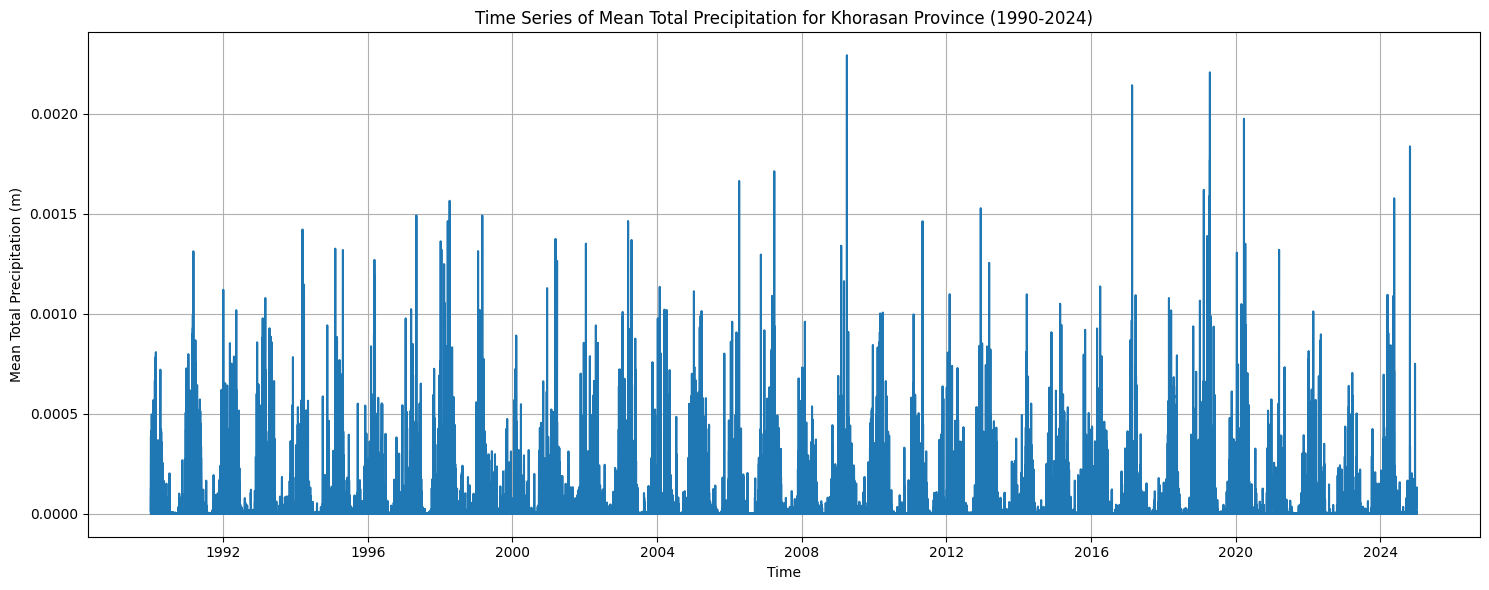

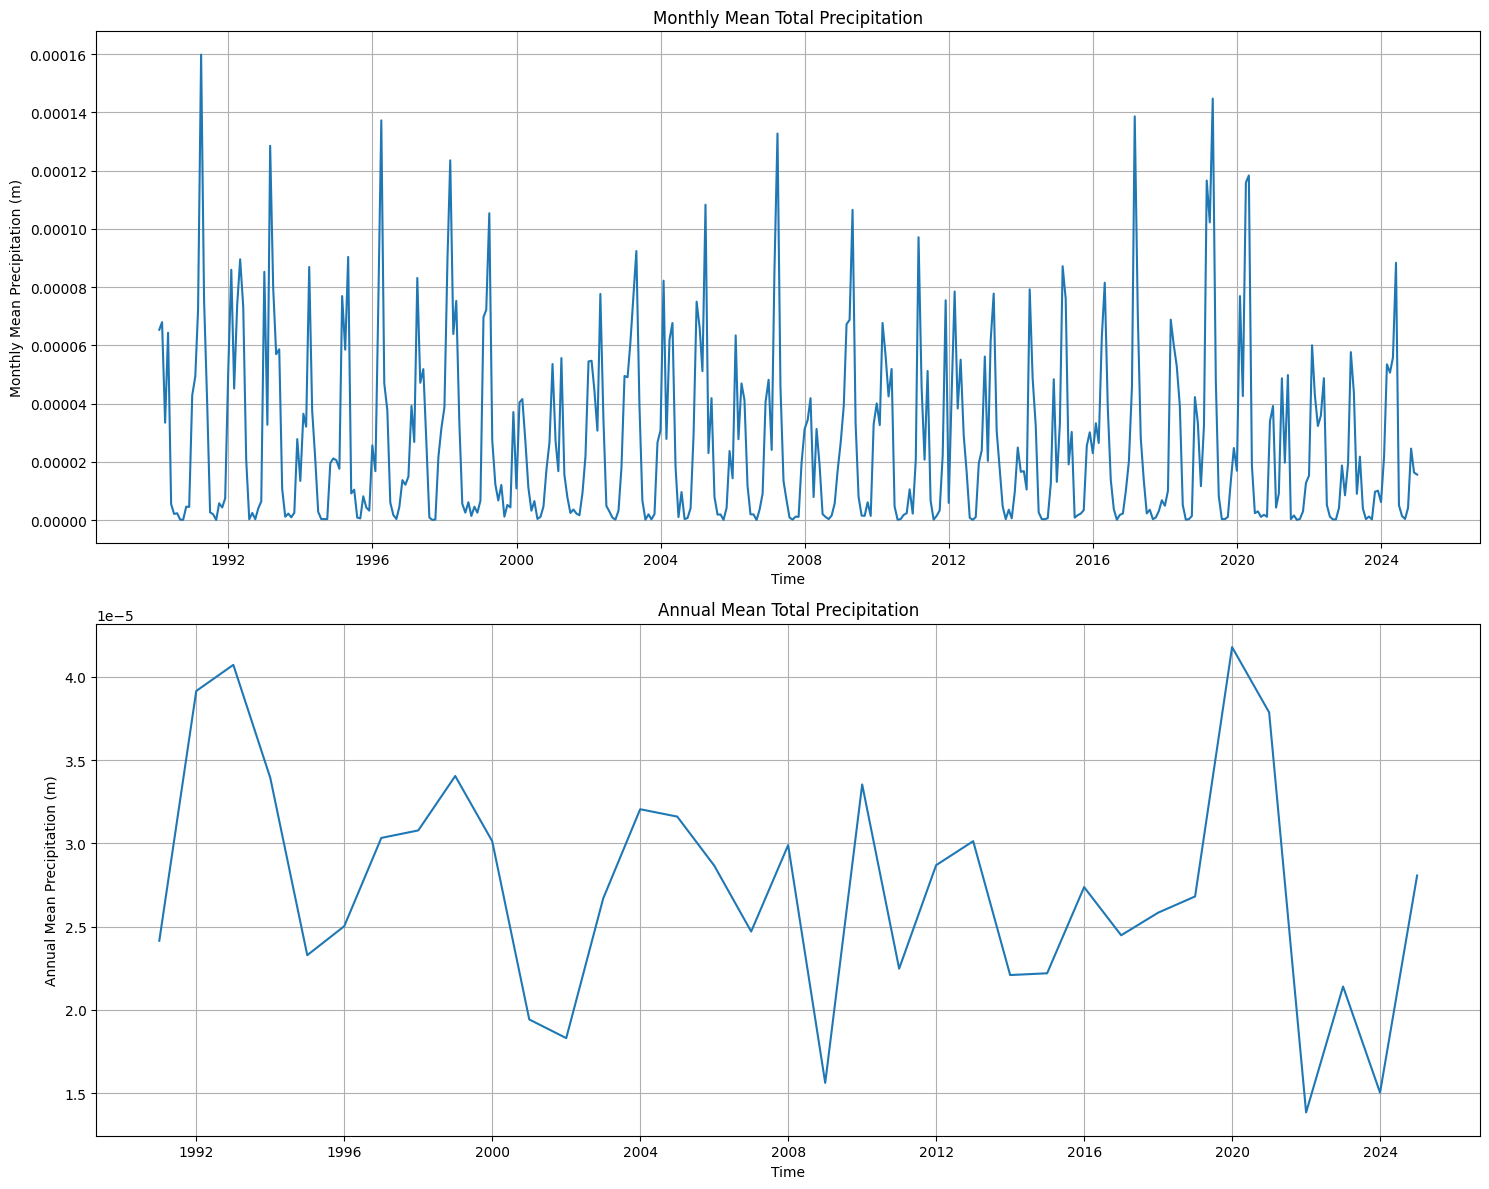

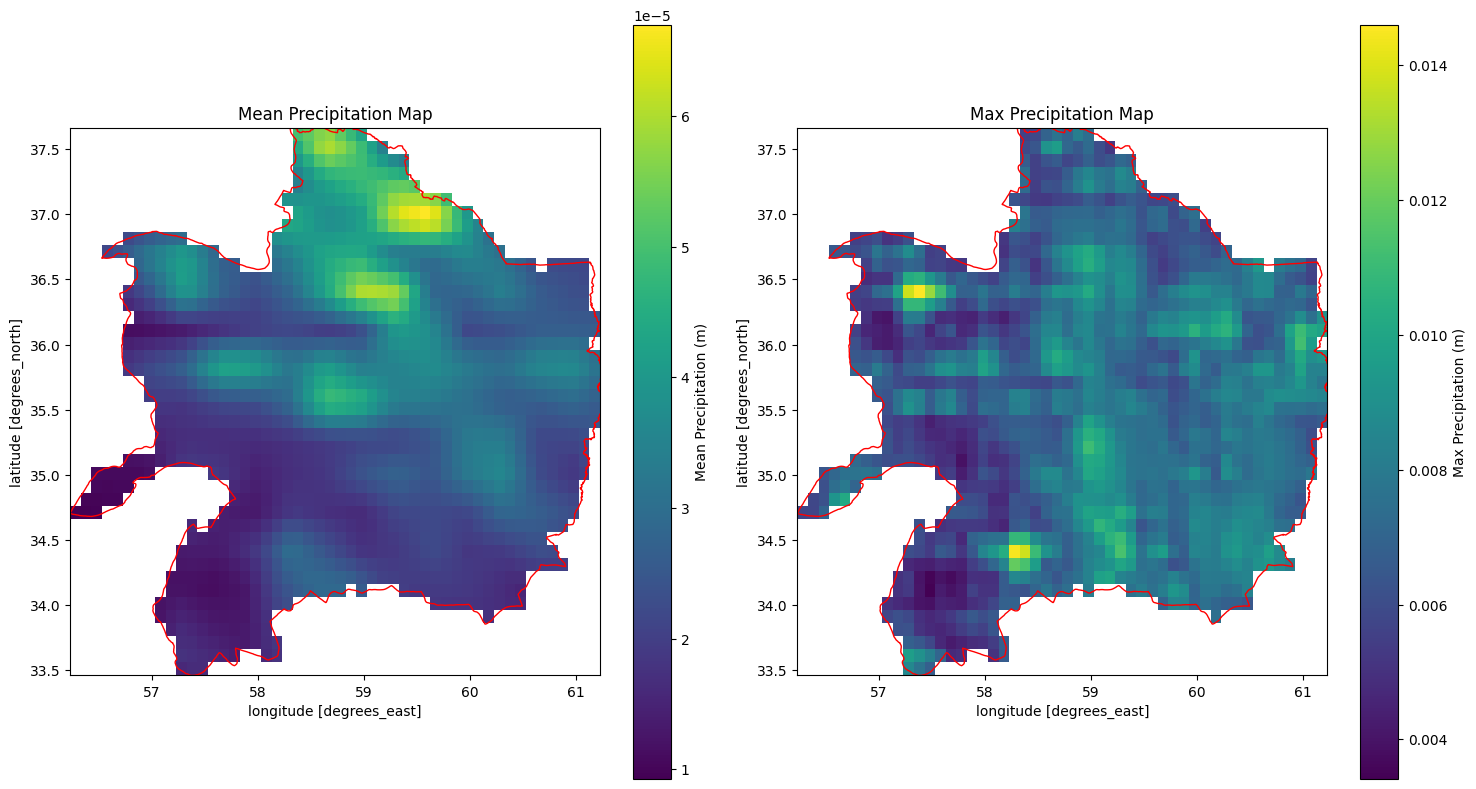

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray

# --- Configuration ---
# File paths for your data and shapefile
netcdf_path = "Pr1990_2024_combined.nc"
shapefile_path = "Province_Khorasan/province.shp"

# --- Main Script ---
try:
    print("Loading data...")
    # Load the NetCDF dataset
    era5_ds = xr.open_dataset(netcdf_path)

    # Load the shapefile using geopandas
    gdf = gpd.read_file(shapefile_path)
    
    # --- FIX for the dimension error ---
    # Explicitly set the spatial dimensions for rioxarray
    era5_ds = era5_ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

    # Set the CRS of the xarray dataset using rioxarray.
    # We assume the data is already in WGS84 (EPSG:4326), which is common.
    era5_ds.rio.write_crs("epsg:4326", inplace=True)

    # Clip the dataset to the boundaries of the shapefile
    # This process selects only the grid cells that fall within the shapefile's geometry
    print("Clipping data to ROI...")
    clipped_ds = era5_ds.rio.clip(gdf.geometry, gdf.crs, drop=True)

    # Calculate the mean of 'total_precipitation_hourly' over the clipped region's
    # latitude and longitude dimensions to create a single time series
    print("Calculating mean precipitation...")
    mean_precipitation_hourly = clipped_ds['total_precipitation_hourly'].mean(dim=['lon', 'lat'])

    # --- Plotting: Original Hourly Time Series ---
    print("Generating hourly time series plot...")
    plt.figure(figsize=(15, 6))
    mean_precipitation_hourly.plot()
    plt.title('Time Series of Mean Total Precipitation for Khorasan Province (1990-2024)')
    plt.xlabel('Time')
    plt.ylabel('Mean Total Precipitation (m)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('khorasan_precipitation_hourly_time_series.png')

    # --- Plotting: Resampled Monthly and Annual Time Series ---
    print("Generating monthly and annual time series plots...")
    
    # Resample the hourly data to a monthly and annual frequency
    mean_precipitation_monthly = mean_precipitation_hourly.resample(time="M").mean()
    mean_precipitation_annual = mean_precipitation_hourly.resample(time="Y").mean()
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot monthly data
    mean_precipitation_monthly.plot(ax=axes[0])
    axes[0].set_title('Monthly Mean Total Precipitation')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Monthly Mean Precipitation (m)')
    axes[0].grid(True)
    
    # Plot annual data
    mean_precipitation_annual.plot(ax=axes[1])
    axes[1].set_title('Annual Mean Total Precipitation')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Annual Mean Precipitation (m)')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('khorasan_precipitation_monthly_annual_time_series.png')

    # --- Plotting: Mean and Max Maps ---
    print("Generating mean and max maps...")
    
    # Calculate the mean and max over the time dimension
    mean_map = clipped_ds['total_precipitation_hourly'].mean(dim='time')
    max_map = clipped_ds['total_precipitation_hourly'].max(dim='time')
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    
    # Plot Mean Map
    # Use x='lon' and y='lat' to ensure correct orientation
    mean_map.plot(ax=axes[0], x='lon', y='lat', cmap='viridis', cbar_kwargs={'label': 'Mean Precipitation (m)'})
    axes[0].set_title('Mean Precipitation Map')
    gdf.plot(ax=axes[0], facecolor='none', edgecolor='red', linewidth=1)
    
    # Plot Max Map
    # Use x='lon' and y='lat' to ensure correct orientation
    max_map.plot(ax=axes[1], x='lon', y='lat', cmap='viridis', cbar_kwargs={'label': 'Max Precipitation (m)'})
    axes[1].set_title('Max Precipitation Map')
    gdf.plot(ax=axes[1], facecolor='none', edgecolor='red', linewidth=1)
    
    plt.tight_layout()
    plt.savefig('khorasan_precipitation_maps.png')

    print("All charts and maps have been saved successfully.")

except FileNotFoundError as e:
    print(f"Error: A file was not found. Please check the paths. Details: {e}")
except KeyError as e:
    print(f"Error: A data variable or coordinate was not found in the dataset. Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred. Details: {e}")


In [5]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Define station information with paths
stations = [
    {"name": "Jaghargh", "lat": 36.3114864, "lon": 59.3224514, "path": "data_validation/Jaghargh.xlsx"},
    {"name": "Zoshk", "lat": 36.3385960, "lon": 59.1953066, "path": "data_validation/Zoshk.xlsx"},
    {"name": "Edareh", "lat": 36.3217200, "lon": 59.5684300, "path": "data_validation/Edareh.xlsx"},
    {"name": "Radkan", "lat": 36.8039817, "lon": 59.0101517, "path": "data_validation/Radkan.xlsx"},
    {"name": "Andarkh", "lat": 36.5820760, "lon": 59.6607562, "path": "data_validation/Andarkh.xlsx"},
    {"name": "Chenaran", "lat": 36.6462594, "lon": 59.1161501, "path": "data_validation/Chenaran.xlsx"},
    {"name": "Shandiz", "lat": 36.3995647, "lon": 59.3389961, "path": "data_validation/Shandiz.xlsx"},
    {"name": "Ferizi", "lat": 36.4884911, "lon": 58.9787934, "path": "data_validation/Ferizi.xlsx"},
    {"name": "Torogh", "lat": 36.1727771, "lon": 59.5526764, "path": "data_validation/Torogh.xlsx"}
]

# Load ERA5 NetCDF file
file_path = r"Pr1990_2024_combined.nc"
era5_ds = xr.open_dataset(file_path)
era5_precip = era5_ds['total_precipitation_hourly']

# Convert ERA5 precipitation from meters to millimeters
era5_precip_mm = era5_precip * 1000  # 1 m = 1000 mm

# Function to find nearest grid point
def find_nearest_grid(lat, lon, lat_array, lon_array):
    lat_idx = np.abs(lat_array - lat).argmin()
    lon_idx = np.abs(lon_array - lon).argmin()
    return lat_idx, lon_idx

# Create output directory for plots
output_dir = "scatter_plots"
os.makedirs(output_dir, exist_ok=True)

# Process each station
for station in stations:
    name = station['name']
    lat = station['lat']
    lon = station['lon']
    excel_path = station['path']
    
    # Load observation data
    try:
        obs_df = pd.read_excel(excel_path)
    except FileNotFoundError:
        print(f"Excel file for {name} not found at {excel_path}. Skipping...")
        continue
    
    # Combine Date and Hour into a single datetime column
    obs_df['DateTime'] = pd.to_datetime(obs_df['Date'].astype(str) + ' ' + obs_df['Hour'].astype(str))
    obs_df.set_index('DateTime', inplace=True)
    
    # Extract ERA5 data for the nearest grid point
    lat_idx, lon_idx = find_nearest_grid(lat, lon, era5_ds.lat.values, era5_ds.lon.values)
    era5_station = era5_precip_mm.isel(lat=lat_idx, lon=lon_idx).to_dataframe()['total_precipitation_hourly']
    
    # Align ERA5 data with observation dates
    common_dates = obs_df.index.intersection(era5_station.index)
    if len(common_dates) == 0:
        print(f"No overlapping dates for {name}. Skipping...")
        continue
    
    obs_data = obs_df.loc[common_dates, 'Hourly_Rain']
    era5_data = era5_station.loc[common_dates]
    
    # Remove NaN values for correlation and plotting
    valid_mask = ~obs_data.isna() & ~era5_data.isna()
    obs_valid = obs_data[valid_mask]
    era5_valid = era5_data[valid_mask]
    
    # Calculate Pearson correlation
    if len(obs_valid) >= 2:
        corr, p_value = pearsonr(obs_valid, era5_valid)
        corr_text = f'Correlation: {corr:.3f}\np-value: {p_value:.3e}'
        print(f"{name} Correlation: {corr:.3f}, p-value: {p_value:.3e}")
    else:
        corr_text = 'Insufficient data for correlation'
        print(f"Insufficient valid data for correlation at {name}.")
    
    # Plotting scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(obs_valid, era5_valid, alpha=0.5, color='blue')
    # Add 1:1 line
    max_val = max(obs_valid.max(), era5_valid.max())
    plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='1:1 Line')
    plt.xlabel('Observation Precipitation (mm)')
    plt.ylabel('ERA5 Precipitation (mm)')
    plt.title(f'ERA5 vs Observation Precipitation at {name} (ERA5 in mm)')
    plt.legend()
    plt.grid(True)
    
    # Add correlation text to the plot
    plt.text(0.02, 0.98, corr_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(output_dir, f"{name}_scatter.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Scatter plot saved for {name} at {plot_path}")

# Close the NetCDF file
era5_ds.close()

Jaghargh Correlation: 0.358, p-value: 7.792e-94
Scatter plot saved for Jaghargh at scatter_plots\Jaghargh_scatter.png
Zoshk Correlation: 0.324, p-value: 6.865e-153
Scatter plot saved for Zoshk at scatter_plots\Zoshk_scatter.png
Edareh Correlation: 0.262, p-value: 2.106e-61
Scatter plot saved for Edareh at scatter_plots\Edareh_scatter.png
Radkan Correlation: 0.344, p-value: 0.000e+00
Scatter plot saved for Radkan at scatter_plots\Radkan_scatter.png
Andarkh Correlation: 0.337, p-value: 0.000e+00
Scatter plot saved for Andarkh at scatter_plots\Andarkh_scatter.png
Chenaran Correlation: 0.368, p-value: 1.213e-122
Scatter plot saved for Chenaran at scatter_plots\Chenaran_scatter.png
Shandiz Correlation: 0.166, p-value: 1.266e-132
Scatter plot saved for Shandiz at scatter_plots\Shandiz_scatter.png
Ferizi Correlation: 0.267, p-value: 0.000e+00
Scatter plot saved for Ferizi at scatter_plots\Ferizi_scatter.png
Torogh Correlation: -0.013, p-value: 7.817e-01
Scatter plot saved for Torogh at scatte